In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import utils # local file

#plt.rcParams['figure.dpi'] = 200.0
#plt.rcParams['figure.facecolor'] = 'w'
#plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 15.0
#plt.rcParams['text.usetex'] = False

In [2]:
df = pd.read_csv('./2020_Problem_D_DATA/passingevents.csv')
df = df[df['MatchID'] == 1]
# df.sort_values('TeamID')
# df = df[np.logical_or(df['TeamID'] == 'Huskies', df['TeamID'] == 'Opponent1')]
df

,MatchID,TeamID,OriginPlayerID,DestinationPlayerID,MatchPeriod,EventTime,EventSubType,EventOrigin_x,EventOrigin_y,EventDestination_x,EventDestination_y
0,1,Huskies,Huskies_D1,Huskies_F1,1H,46.323501,Head pass,34,97,59.0,95.0
1,1,Huskies,Huskies_M1,Huskies_F2,1H,51.022546,Simple pass,53,89,69.0,91.0
2,1,Opponent1,Opponent1_D2,Opponent1_G1,1H,89.008721,Simple pass,19,16,5.0,50.0
3,1,Opponent1,Opponent1_G1,Opponent1_F1,1H,92.216160,Launch,5,50,67.0,44.0
4,1,Huskies,Huskies_M2,Huskies_M3,1H,98.265191,Simple pass,42,55,36.0,54.0
...,...,...,...,...,...,...,...,...,...,...,...
561,1,Huskies,Huskies_F2,Huskies_M5,2H,2825.780227,High pass,74,61,98.0,72.0
562,1,Huskies,Huskies_M5,Huskies_F2,2H,2836.145109,Simple pass,88,93,79.0,91.0
563,1,Huskies,Huskies_F2,Huskies_M1,2H,2841.121956,Simple pass,79,91,84.0,86.0
564,1,Huskies,Huskies_M1,Huskies_M5,2H,2842.836213,Simple pass,84,86,85.0,95.0


In [4]:
df = df[df['TeamID'] == 'Huskies'] # We only study Huskies now

In [5]:
# calculate average position of each player
uniq_player = np.unique(
    np.union1d(df['OriginPlayerID'], df['DestinationPlayerID']))
x_mean = [
    np.mean(
        list(df[df['OriginPlayerID'] == name]['EventOrigin_x']) +
        list(df[df['DestinationPlayerID'] == name]['EventDestination_x']))
    for name in uniq_player
]
y_mean = [
    np.mean(
        list(df[df['OriginPlayerID'] == name]['EventOrigin_y']) +
        list(df[df['DestinationPlayerID'] == name]['EventDestination_y']))
    for name in uniq_player
]

pos = {
    name: np.array([x_mean[i], y_mean[i]])
    for i, name in enumerate(uniq_player)
}

In [7]:
# Build Directional graph
G = nx.from_pandas_edgelist(df, source='OriginPlayerID', 
                            target='DestinationPlayerID', 
                            edge_attr=True, 
                            create_using=nx.DiGraph())

In [29]:
# Calculate degree centrality
deg_centrality = nx.algorithms.centrality.degree_centrality(G)
deg_centrality = np.array([deg_centrality[node] for node in list(G.nodes())])

# Calculate betweenness centrality
between_centrality = nx.algorithms.centrality.betweenness_centrality(G)
between_centrality = np.array([between_centrality[node] for node in list(G.nodes())])

# Calculate total (in + out) passes through a node
huskie_passes = utils.match_i_Huskies_passing_table('./2020_Problem_D_DATA/passingevents.csv', match_i=1)
node_passes = np.array([np.sum(huskie_passes[node]) for node in list(G.nodes())])

In [14]:
## Calculate passes from A to B
df_huskies = df[['OriginPlayerID', 'DestinationPlayerID']]
# Multi-Directional graph
H = nx.from_pandas_edgelist(df_huskies, source='OriginPlayerID', 
                            target='DestinationPlayerID', edge_attr=True, 
                            create_using=nx.MultiDiGraph())

unidirection_pass = {}
for edge in H.edges:
    unidirection_pass[(edge[0], edge[1])] = H.number_of_edges(edge[0], edge[1])

In [43]:
max(np.exp(50 * between_centrality))

221.74572422260903

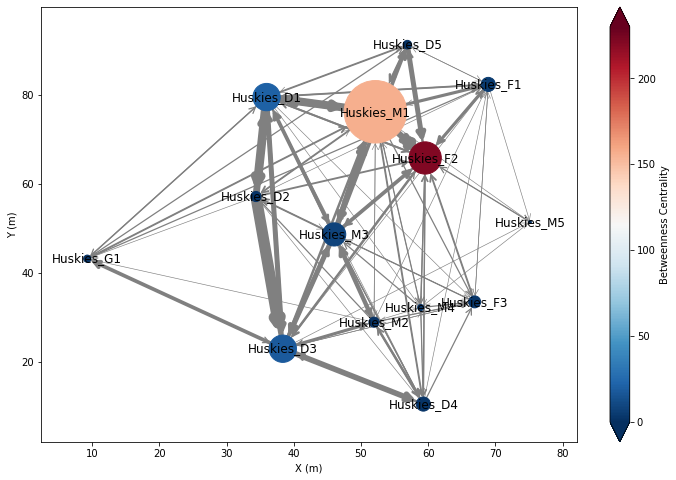

In [49]:
# Plot the network
fig, ax = plt.subplots(figsize=(12, 8))
nx.draw_networkx(G, pos, ax=ax, 
                 node_size=np.exp(4.3 * deg_centrality), 
                 node_color=np.exp(50 * between_centrality), 
                 edgelist=list(unidirection_pass.keys()), 
                 width=np.array(list(unidirection_pass.values())) / 1.6,
                 edge_color='gray', cmap='RdBu_r', vmin=0, vmax=230, arrowsize=15, arrowstyle='->')
ax.set_xlabel('X (m)')
ax.set_ylabel('Y (m)')

sm = plt.cm.ScalarMappable(cmap='RdBu_r', norm=plt.Normalize(vmin=0, vmax=230))
cbar = plt.colorbar(sm, ax=ax, extend='both')
cbar.set_label('Betweenness Centrality')
#fig.colorbar(neg, ax=ax)
#, width=edge_passes)

In [91]:
# get attributes of an edge
G.get_edge_data('Huskies_D3', 'Huskies_D2')

{'MatchID': 1,
 'TeamID': 'Huskies',
 'OriginPlayerID': 'Huskies_D3',
 'DestinationPlayerID': 'Huskies_D2',
 'MatchPeriod': '1H',
 'EventTime': 766.375013,
 'EventSubType': 'Simple pass',
 'EventOrigin_x': 26,
 'EventOrigin_y': 15,
 'EventDestination_x': 28.0,
 'EventDestination_y': 46.0}